In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

### Действия для ga_hits

- удалить event_value (пустой), hit_type (все значения одинаковые)
- заполнить пропуски hit_time средним значением
- заполнить пропуски event_label модой
- заполнить пропуски hit_referer модой

# Загрузка данных

In [2]:
step = 3
hits_df = pd.read_csv('data/ga_hits.csv', skiprows=lambda x: x % step != 0) 
# всего 15 726 470 строк 

In [3]:
hits_df.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
1,6466333295973247896.1640246168.1640246168,2021-12-23,704194.0,41,event,NaN,sberauto.com/cars?utm_source_initial=youtube&u...,quiz,quiz_show,NaN,NaN
2,555009234841130092.1640256620.1640256620,2021-12-23,1013899.0,101,event,VloVXNWduHeTjUoDkjkO,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,quiz,quiz_show,NaN,NaN
3,4555345648396008371.1640233907.1640233907,2021-12-23,107.0,4,event,trXmoxcphNjuYcShOXwL,sberauto.com/cars/all/nissan/qashqai/bfc21661?...,card_web,view_card,NaN,NaN
4,9063469723165129646.1640233902.1640233902,2021-12-23,68.0,3,event,uMnMdxLOIznakHyXLoMC,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,card_web,view_card,NaN,NaN


In [4]:
hits_df.shape

(5242156, 11)

# Разведочный анализ

Целевая переменная - event_action

## Обработка пропущенных значений

<AxesSubplot:>

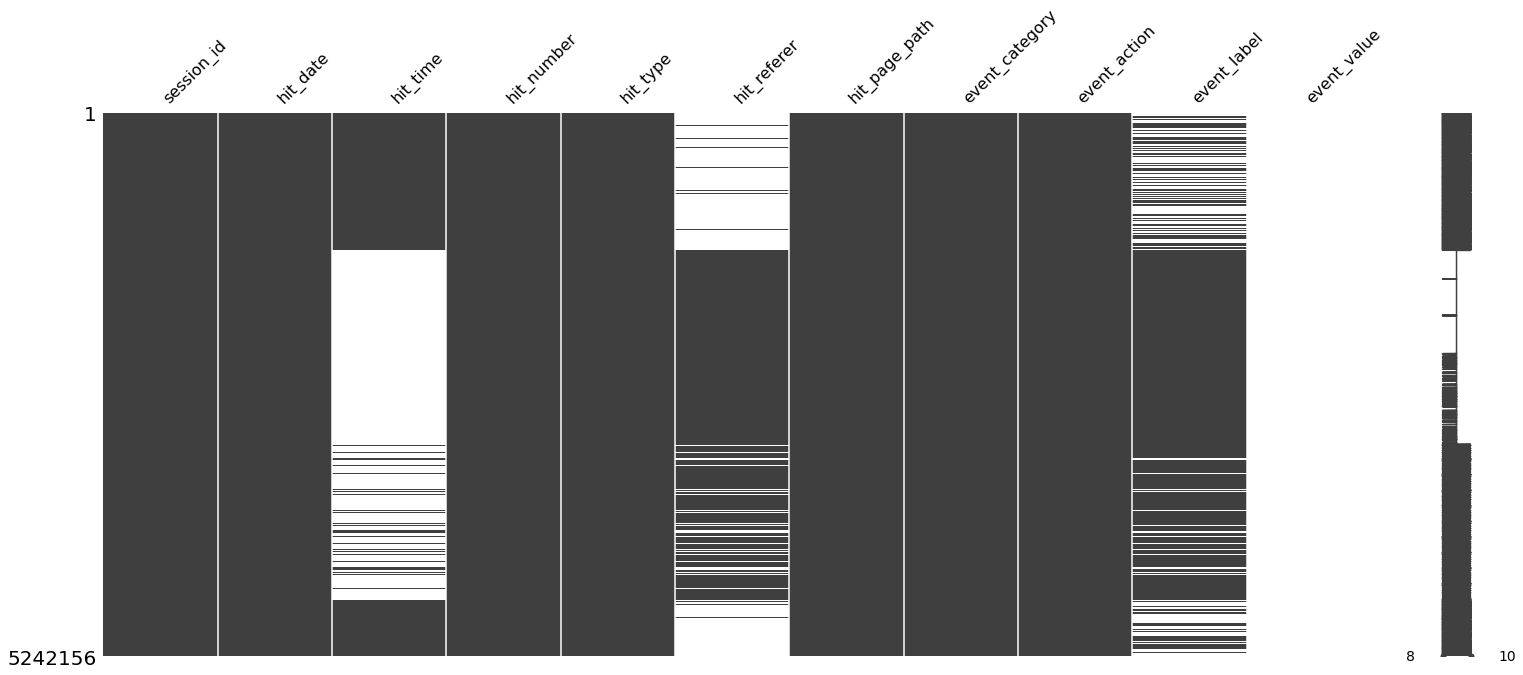

In [5]:
msno.matrix(hits_df)

In [6]:
hits_new = hits_df.copy()

In [7]:
hits_new['hit_type'].value_counts()

event    5242156
Name: hit_type, dtype: int64

In [8]:
# event_value полностью пуст, удаляем
# все значения hit_type однинаковые, удаляем

hits_new = hits_new.drop(['event_value', 'hit_type'], axis=1)

In [9]:
# процент пропущенных значений
def missing_values(df):
    return ((df.isna().sum() / len(df)) * 100).sort_values()

In [10]:
missing_values(hits_new)

session_id         0.000000
hit_date           0.000000
hit_number         0.000000
hit_page_path      0.000000
event_category     0.000000
event_action       0.000000
event_label       23.910334
hit_referer       39.903162
hit_time          58.246798
dtype: float64

### Hit_time

(array([2.135869e+06, 4.302900e+04, 6.917000e+03, 1.893000e+03,
        6.450000e+02, 2.230000e+02, 9.400000e+01, 4.900000e+01,
        3.500000e+01, 1.400000e+01]),
 array([       0. ,  1315688.3,  2631376.6,  3947064.9,  5262753.2,
         6578441.5,  7894129.8,  9209818.1, 10525506.4, 11841194.7,
        13156883. ]),
 <BarContainer object of 10 artists>)

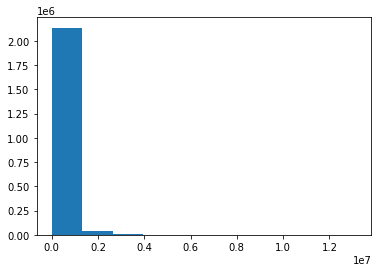

In [11]:
plt.hist(hits_new['hit_time'])

In [12]:
hits_new['hit_time'].value_counts()

0.0          13576
1.0           6117
2.0           3314
3.0           2008
4.0           1501
             ...  
486903.0         1
1153840.0        1
1466332.0        1
453430.0         1
2172865.0        1
Name: hit_time, Length: 582924, dtype: int64

In [13]:
hits_new['hit_time'].mean()

209328.07916325532

In [14]:
# заполним пропуски средним значением
hits_new['hit_time'] = hits_new['hit_time'].fillna(hits_new['hit_time'].mean())

### Event_label

In [15]:
hits_new['event_label'].value_counts()

KclpemfoHstknWHFiLit    2168454
hAHqGICPFQiPwtzubOzs     428346
OHfyUfDKdPgBdvelDlfG     208731
pzAKUYdRKNEUXxxBFUPX     119498
ghOrjqpgskpGHSFfBBsi     114090
                         ...   
aDWkTuyIexNGAQfWnDlJ          1
zdAZMCPStPvGvEsLGpUG          1
vArAYanGPQaroLUkrQQW          1
eFPwPmKhDcnlAKffPvHw          1
zCMGPrpNkfsTcYWqMUzJ          1
Name: event_label, Length: 20173, dtype: int64

In [16]:
# заполним пропуски модой
hits_new['event_label'] = hits_new['event_label'].fillna(hits_new['event_label'].mode().iloc[0])

### Hit_referer 

In [17]:
hits_new['hit_referer'].value_counts()

HbolMJUevblAbkHClEQa    2959840
FwdMTcXzWAwhtsnMAbhS      30548
sAGDBCdeVPmQPwkVEcIX      17729
GQmOLxANuSeCxCanBpMl      11790
ZeRnFrHdnMmnqraghdGJ       7672
                         ...   
BpAykXrUhrVvaLVxDsLI          1
xXkCApdVuppgaAGHtBkD          1
kGoDnujCfppPFmrbwMLF          1
CtfEJTPRMsUzvEilqSOC          1
tvGabHlPFDvTmIFiCKTL          1
Name: hit_referer, Length: 23389, dtype: int64

In [18]:
# заполним пропуски модой
hits_new['hit_referer'] = hits_new['hit_referer'].fillna(hits_new['hit_referer'].mode().iloc[0])

### Проверка

In [19]:
missing_values(hits_new)

session_id        0.0
hit_date          0.0
hit_time          0.0
hit_number        0.0
hit_referer       0.0
hit_page_path     0.0
event_category    0.0
event_action      0.0
event_label       0.0
dtype: float64

In [22]:
# сохраним получившийся датасет

hits_new.to_csv('data/ga_hits(2.0).csv', index=False)

## Приведение типов

In [20]:
hits_new.dtypes

session_id         object
hit_date           object
hit_time          float64
hit_number          int64
hit_referer        object
hit_page_path      object
event_category     object
event_action       object
event_label        object
dtype: object

In [21]:
hits_new.head()

,session_id,hit_date,hit_time,hit_number,hit_referer,hit_page_path,event_category,event_action,event_label
0,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,HbolMJUevblAbkHClEQa,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,KclpemfoHstknWHFiLit
1,6466333295973247896.1640246168.1640246168,2021-12-23,704194.0,41,HbolMJUevblAbkHClEQa,sberauto.com/cars?utm_source_initial=youtube&u...,quiz,quiz_show,KclpemfoHstknWHFiLit
2,555009234841130092.1640256620.1640256620,2021-12-23,1013899.0,101,VloVXNWduHeTjUoDkjkO,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,quiz,quiz_show,KclpemfoHstknWHFiLit
3,4555345648396008371.1640233907.1640233907,2021-12-23,107.0,4,trXmoxcphNjuYcShOXwL,sberauto.com/cars/all/nissan/qashqai/bfc21661?...,card_web,view_card,KclpemfoHstknWHFiLit
4,9063469723165129646.1640233902.1640233902,2021-12-23,68.0,3,uMnMdxLOIznakHyXLoMC,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,card_web,view_card,KclpemfoHstknWHFiLit
